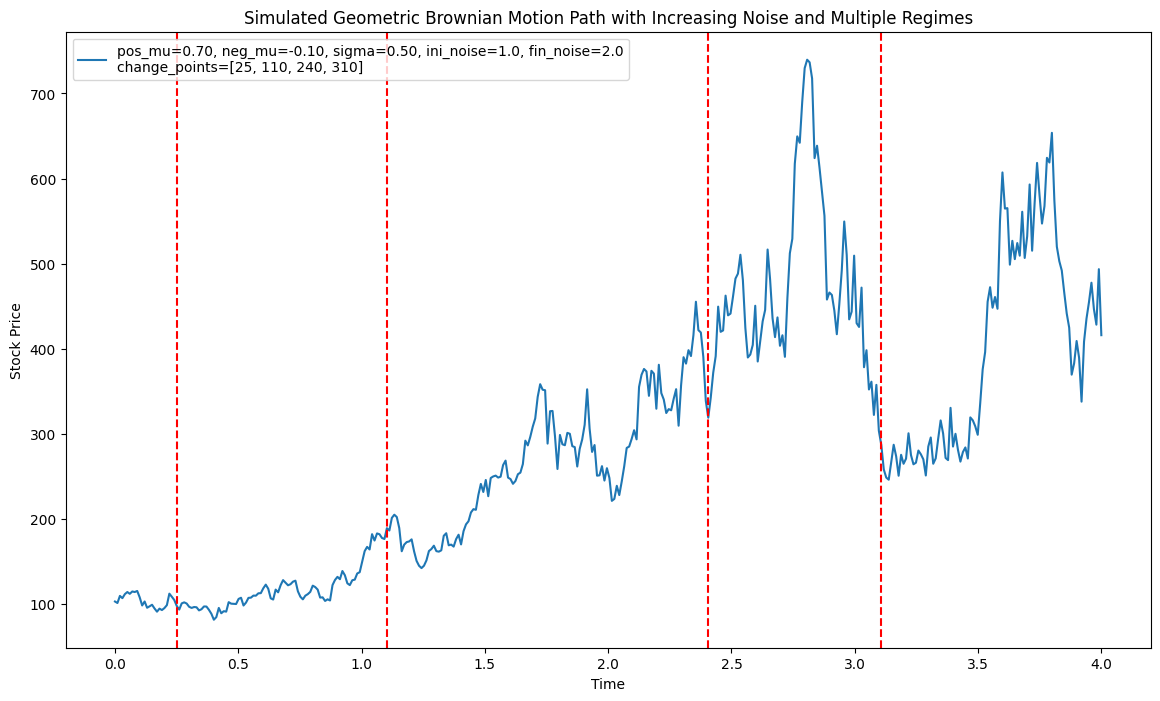

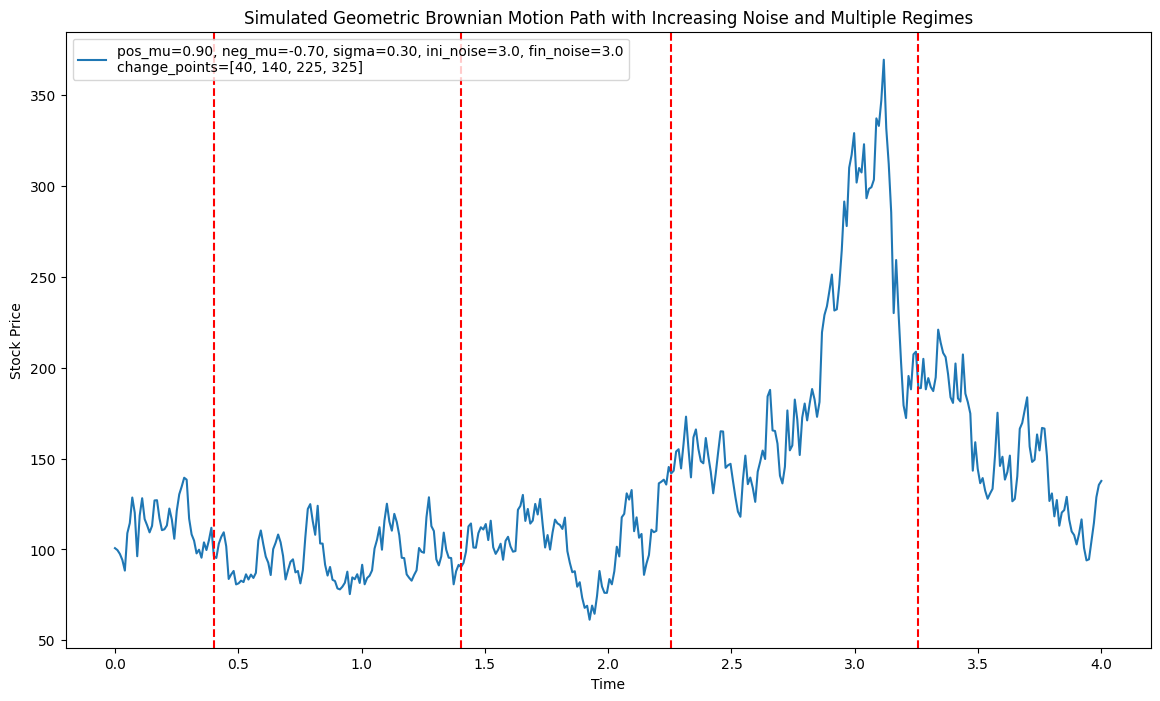

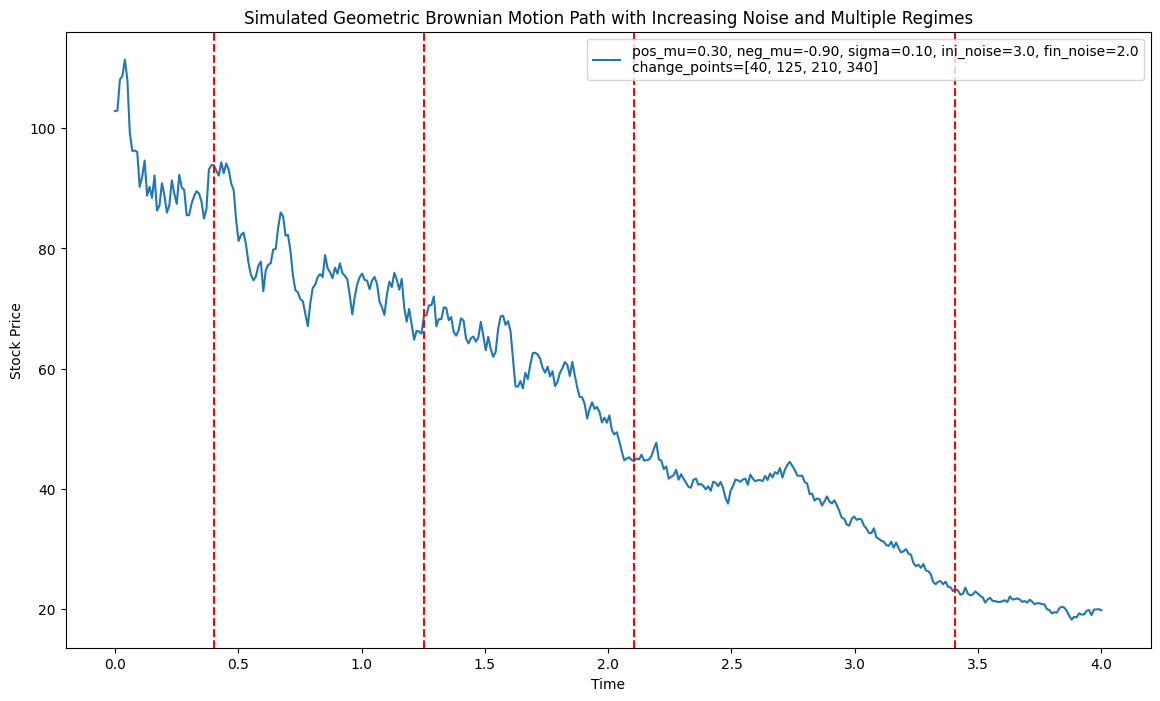

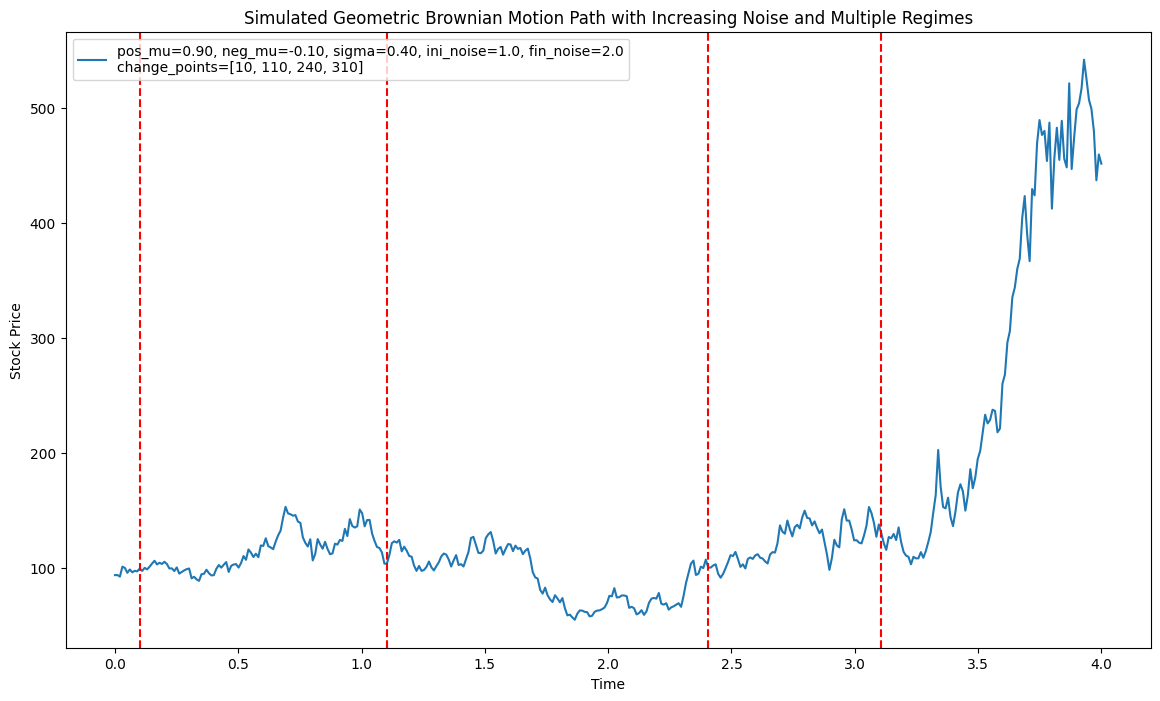

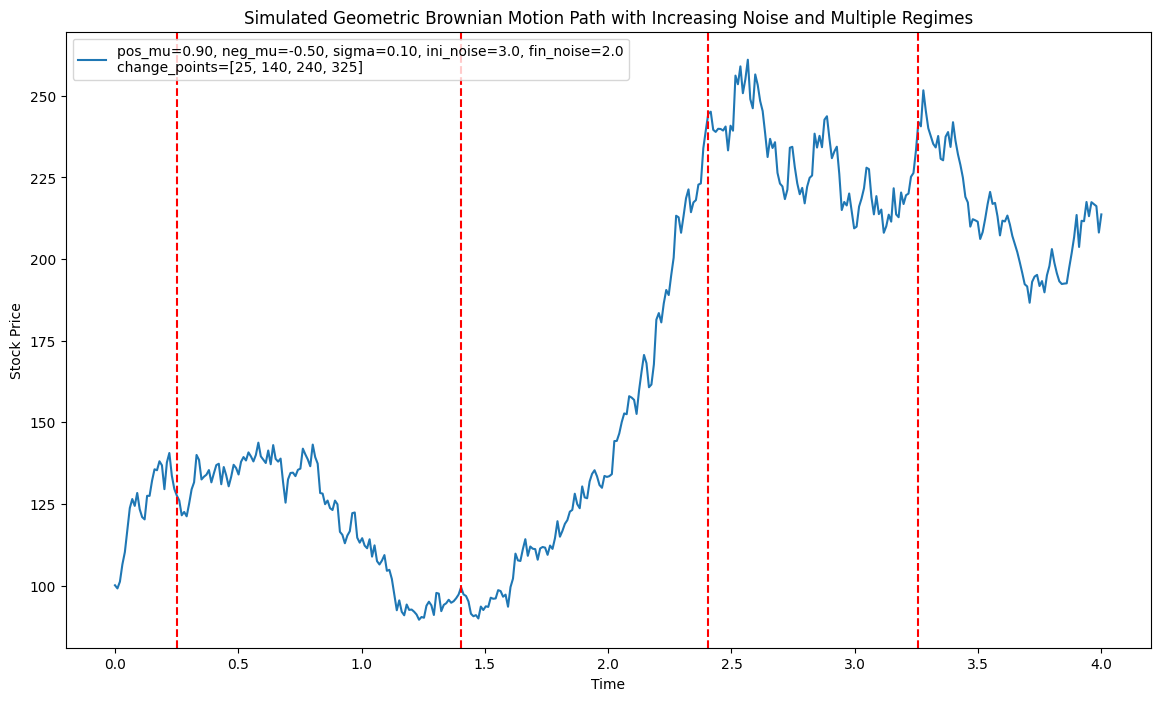

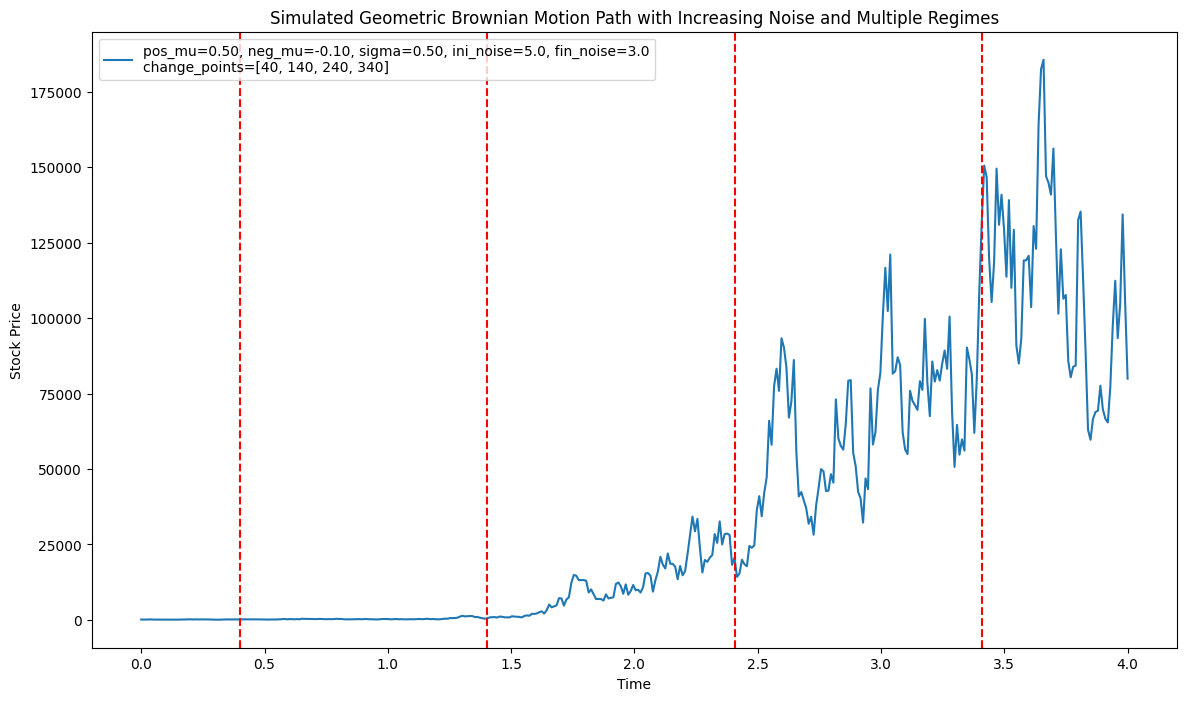

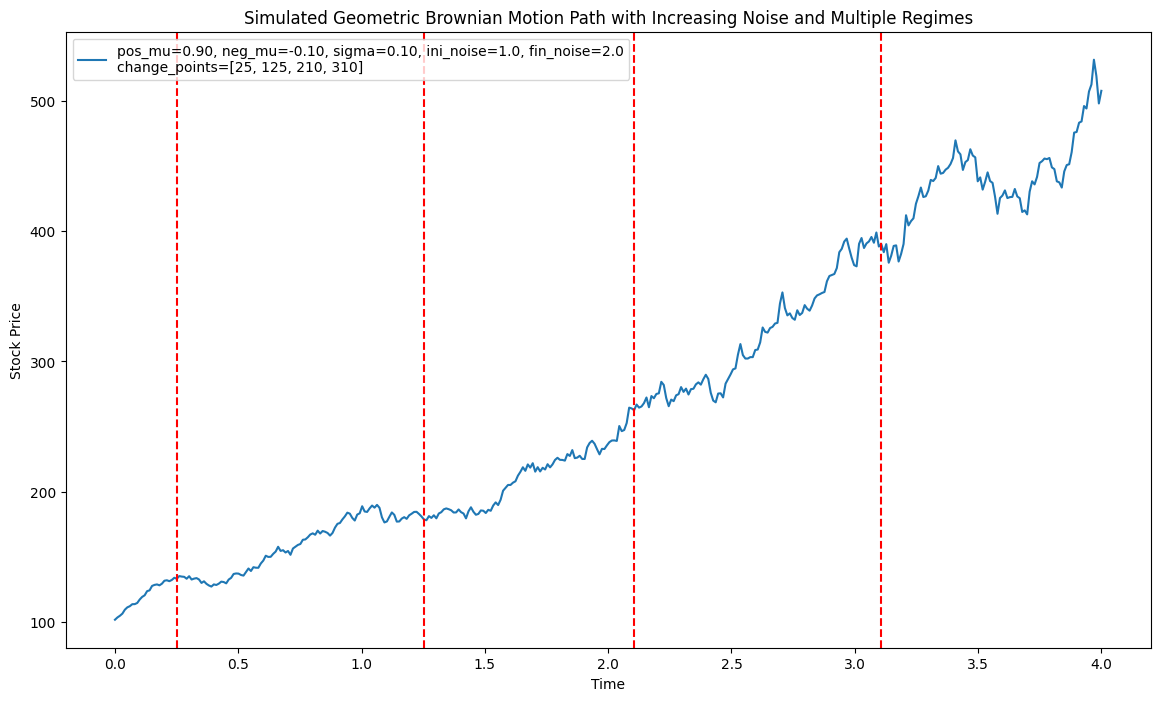

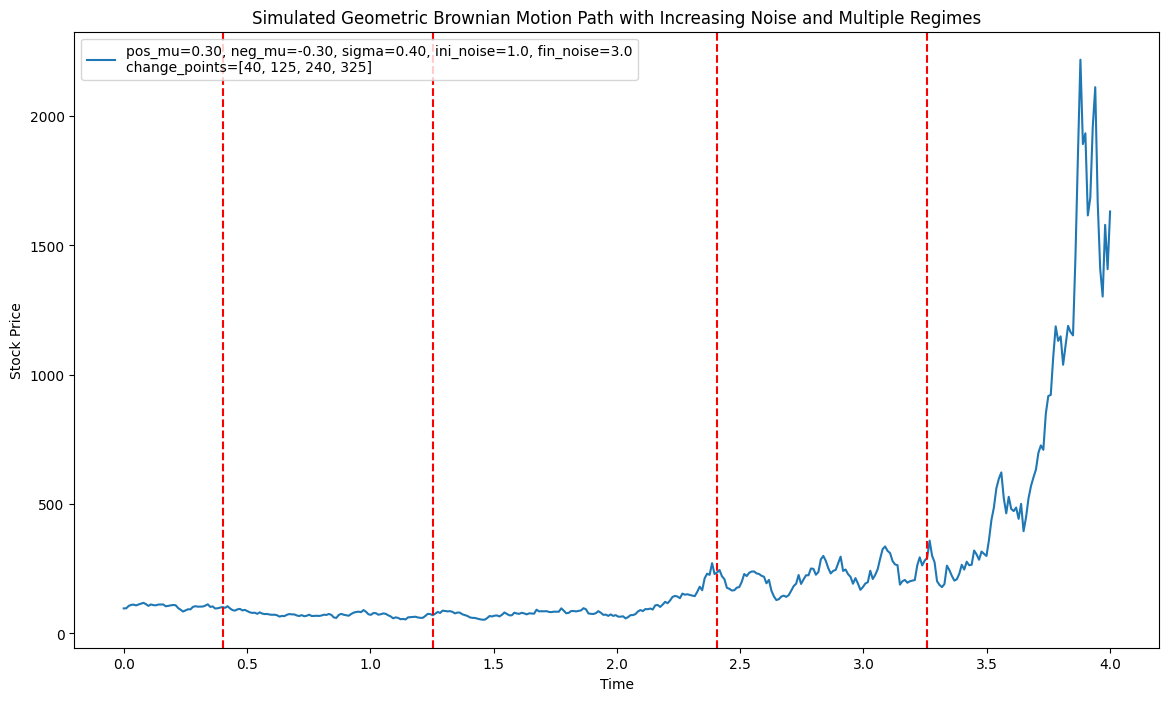

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import random

def simulate_gbm_with_multiple_regimes(S0, pos_mu, neg_mu, sigma, T, dt, n_paths, initial_noise_factors, final_noise_factors, change_points, all_combinations=True, sample_size=10, seed=None):
    """
    Simulate multiple paths of Geometric Brownian Motion with multiple regime shifts and increasing noise.

    Parameters:
    S0 (float): Initial stock price
    pos_mu (list): List of positive drift rates
    neg_mu (list): List of negative drift rates
    sigma (list): List of volatility rates
    T (float): Total time (in years)
    dt (float): Time step
    n_paths (int): Number of paths to simulate
    initial_noise_factors (list): List of initial noise factors
    final_noise_factors (list): List of final noise factors
    change_points (list): List of change points (as a fraction of each pair length)
    all_combinations (bool): If True, simulate all possible combinations. If False, use sample_size to sample combinations.
    sample_size (int): Number of random combinations to sample if all_combinations is False
    seed (int, optional): Random seed for reproducibility

    Returns:
    tuple: (time_grid, paths, selected_combinations, change_steps_dict) where time_grid is a numpy array, paths is a dictionary of simulated paths for each (pos_mu, neg_mu, sigma, initial_noise_factor, final_noise_factor) pair, selected_combinations is the list of combinations used for simulation, and change_steps_dict is a dictionary of change points for each combination
    """
    if seed is not None:
        np.random.seed(seed)

    n_steps = 400
    pair_length = 100
    time_grid = np.linspace(0, T, n_steps)
    paths = {}
    change_steps_dict = {}

    all_combinations_list = list(product(pos_mu, neg_mu, sigma, initial_noise_factors, final_noise_factors))

    if all_combinations:
        selected_combinations = all_combinations_list
    else:
        selected_combinations = random.sample(all_combinations_list, sample_size)

    for (pos_m, neg_m, s, ini_noise, fin_noise) in selected_combinations:
        S = np.ones((n_steps, n_paths)) * S0  # Initialize S with ones multiplied by S0
        change_steps = []

        for i in range(4):
            change_step = int(random.choice(change_points) * (pair_length // 2)) + i * pair_length
            change_steps.append(change_step)
            current_mu = pos_m if i % 2 == 0 else neg_m
            for t in range(i * pair_length, (i + 1) * pair_length):
                Z = np.random.standard_normal(n_paths)
                current_noise_factor = ini_noise + (fin_noise - ini_noise) * (t / n_steps)
                if t >= change_step:
                    current_mu = neg_m if current_mu == pos_m else pos_m
                S[t] = S[t-1] * np.exp((current_mu - 0.5 * s**2) * dt + s * np.sqrt(dt) * Z * current_noise_factor)

        paths[(pos_m, neg_m, s, ini_noise, fin_noise)] = S
        change_steps_dict[(pos_m, neg_m, s, ini_noise, fin_noise)] = change_steps

    return time_grid, paths, selected_combinations, change_steps_dict

def save_simulated_data(time_grid, paths, change_steps_dict, filename):
    """
    Save the simulated paths to a CSV file.

    Parameters:
    time_grid (array): Array of time points
    paths (dict): Dictionary of simulated paths for each (pos_mu, neg_mu, sigma, initial_noise_factor, final_noise_factor) pair
    change_steps_dict (dict): Dictionary of change steps for each combination
    filename (str): Name of the CSV file to save the data
    """
    data = []
    for key, value in paths.items():
        change_steps = change_steps_dict[key]
        for i in range(value.shape[1]):
            path_data = {
                'pos_mu': key[0],
                'neg_mu': key[1],
                'sigma': key[2],
                'initial_noise_factor': key[3],
                'final_noise_factor': key[4],
                'path': i,
                'change_points': ','.join(map(str, change_steps))
            }
            path_data.update({f't_{t}': value[t, i] for t in range(len(time_grid))})
            data.append(path_data)

    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

def plot_selected_paths(time_grid, paths, selected_pairs, change_steps_dict):
    """
    Plot each selected path in a separate figure.

    Parameters:
    time_grid (array): Array of time points
    paths (dict): Dictionary of simulated paths for each (pos_mu, neg_mu, sigma, initial_noise_factor, final_noise_factor) pair
    selected_pairs (list): List of selected pairs (tuples) to plot
    change_steps_dict (dict): Dictionary of change steps for each combination
    """
    for color_idx, key in enumerate(selected_pairs):
        plt.figure(figsize=(14, 8))
        value = paths[key]
        change_steps = change_steps_dict[key]
        label_text = (f'pos_mu={key[0]:.2f}, neg_mu={key[1]:.2f}, '
                      f'sigma={key[2]:.2f}, ini_noise={key[3]:.1f}, '
                      f'fin_noise={key[4]:.1f}\n'
                      f'change_points={change_steps}')
        plt.plot(time_grid, value[:, 0], label=label_text)
        for cp in change_steps:
            plt.axvline(x=time_grid[cp], color='red', linestyle='--')
        plt.title('Simulated Geometric Brownian Motion Path with Increasing Noise and Multiple Regimes')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

# Parameters
S0 = 100  # Initial stock price
pos_mu = np.round(np.linspace(0.1, 0.9, 5), 2)  # Different positive drift rates generated using linspace and rounded
neg_mu = np.round(np.linspace(-0.9, -0.1, 5), 2)  # Different negative drift rates generated using linspace and rounded
sigma = np.round(np.linspace(0.1, 0.5, 5), 2)  # Different volatility rates generated using linspace and rounded
initial_noise_factors = [1.0, 3, 5]  # Different initial noise factors
final_noise_factors = [2.0, 3, 5]  # Different final noise factors
change_points = np.array([0.2, 0.5, 0.8])  # Different change points as fractions of regime length
T = 4.0  # Total time (4 years)
dt = T / 400  # Time step to ensure 400 steps
n_paths = 10  # Number of paths to simulate
seed = 42  # Random seed for reproducibility
sample_size = 100  # Number of random combinations to sample for simulation
plot_sample_size = 8  # Number of random combinations to sample for plotting

# Simulate GBM with multiple regimes and increasing noise
time_grid, paths, selected_combinations, change_steps_dict = simulate_gbm_with_multiple_regimes(S0, pos_mu, neg_mu, sigma, T, dt, n_paths, initial_noise_factors, final_noise_factors, change_points, all_combinations=False, sample_size=sample_size, seed=seed)

# Save the simulated data
filename = 'simulated_gbm_paths_with_multiple_regimes.csv'
save_simulated_data(time_grid, paths, change_steps_dict, filename)

# Sample combinations for plotting
selected_selected_combinations = random.sample(selected_combinations, plot_sample_size)

# Plot each selected path in a separate figure
plot_selected_paths(time_grid, paths, selected_selected_combinations, change_steps_dict)
